In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from scipy import stats

import pymc as pm
import arviz as az
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.power as smp
from functools import reduce

In [ ]:
asthma_df = pd.read_csv('asthma.csv')

In [ ]:
asthma_df.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2016,2016,AR,Arkansas,SEDD; SID,Asthma,Emergency department visit rate for asthma,NaN,NaN,Number,...,5,AST,AST2_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
1,2017,2017,AZ,Arizona,SEDD; SID,Asthma,Emergency department visit rate for asthma,NaN,NaN,Number,...,4,AST,AST2_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
2,2016,2016,CA,California,SEDD; SID,Asthma,Emergency department visit rate for asthma,NaN,NaN,Number,...,6,AST,AST2_1,NMBR,RACE,BLK,NaN,NaN,NaN,NaN
3,2015,2015,CO,Colorado,SEDD; SID,Asthma,Emergency department visit rate for asthma,NaN,NaN,Number,...,8,AST,AST2_1,NMBR,RACE,HIS,NaN,NaN,NaN,NaN
4,2017,2017,CO,Colorado,SEDD; SID,Asthma,Emergency department visit rate for asthma,NaN,NaN,Number,...,8,AST,AST2_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN


In [ ]:
west = ['WA', 'MT', 'OR', 'ID', 'WY', 'NV', 'CA', 'UT', 'CO', 'AK', 'HI']
midwest = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH']
southwest = ['AZ', 'NM', 'TX', 'OK']
south = ['AR', 'LA', 'MS', 'AL', 'TN', 'KY', 'WV', 'VA', 'NC', 'SC', 'GA', 'FL', 'DC']
mid_atlantic = ['PA', 'NY', 'NJ', 'MD', 'DE']
new_england = ['ME', 'VT', 'NH', 'MA', 'CT', 'RI']

In [ ]:
states_dict = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

In [ ]:
## Cleaning Data

# Converting Location to LocationAbbr
race2013_df = pd.read_csv('us-race-2013.csv')
race2013_df['LocationAbbr'] = race2013_df['Location'].replace(states_dict)

race2018_df = pd.read_csv('us-race-2018.csv')
race2018_df['LocationAbbr'] = race2018_df['Location'].replace(states_dict)

# Change in race distributions - measured in proportion of each race
race2013_df = race2013_df.replace("<.01", 0.01)
race2013_df = race2013_df.replace("N/A", 0)
race2013_df = race2013_df.replace("NaN", 0)
#^NA indicated values that were very small so replaced it with 0
race2013_df['Black'] = race2013_df['Black'].astype(float)
race2013_df['American Indian or Alaska Native'] = race2013_df['American Indian or Alaska Native'].astype(float)
race2013_df['Native Hawaiian or Pacific Islander'] = race2013_df['Native Hawaiian or Pacific Islander'].astype(float)
race2013_df['Multiple Races'] = race2013_df['Multiple Races'].astype(float)

race2018_df = race2018_df.replace("<.01", 0.01)
race2018_df = race2018_df.replace("N/A", 0)
race2018_df = race2018_df.replace("NaN", 0)
race2018_df['Black'] = race2018_df['Black'].astype(float)
race2018_df['American Indian or Alaska Native'] = race2018_df['American Indian or Alaska Native'].astype(float)
race2018_df['Native Hawaiian or Pacific Islander'] = race2018_df['Native Hawaiian or Pacific Islander'].astype(float)
race2018_df['Multiple Races'] = race2018_df['Multiple Races'].astype(float)

# Group into Regions
regions = {'West': west, 'Midwest': midwest, 'Southwest': southwest, 'South': south, 'Mid-Atlantic': mid_atlantic, 'New England': new_england}
state_to_region = {}
for state in west:
    state_to_region[state] = 'west'
for state in midwest:
    state_to_region[state] = 'midwest'
for state in southwest:
    state_to_region[state] = 'southwest'
for state in south:
    state_to_region[state] = 'south'
for state in mid_atlantic:
    state_to_region[state] = 'mid_atlantic'
for state in new_england:
    state_to_region[state] = 'new_england'

US_States = ['WA', 'MT', 'OR', 'ID', 'WY', 'NV', 'CA', 'UT', 'CO', 'AK', 'HI', 'ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH', 'AZ', 'NM', 'TX', 'OK','AR', 'LA', 'MS', 'AL', 'TN', 'KY', 'WV', 'VA', 'NC', 'SC', 'GA', 'FL', 'DC','PA', 'NY', 'NJ', 'MD', 'DE','ME', 'VT', 'NH', 'MA', 'CT', 'RI']
filtered_race2013_df = race2013_df[race2013_df['LocationAbbr'].isin(US_States)]
filtered_race2013_df["Region"] = filtered_race2013_df["LocationAbbr"].apply(lambda x: "West" if x in west else
                                       ("Midwest" if x in midwest else
                                        ("Southwest" if x in southwest else
                                         ("South" if x in south else
                                          ("Mid-Atlantic" if x in mid_atlantic else
                                            ("New England" if x in new_england else np.nan))))))

filtered_race2018_df = race2018_df[race2018_df['LocationAbbr'].isin(US_States)]
filtered_race2018_df["Region"] = filtered_race2018_df["LocationAbbr"].apply(lambda x: "West" if x in west else
                                       ("Midwest" if x in midwest else
                                        ("Southwest" if x in southwest else
                                         ("South" if x in south else
                                          ("Mid-Atlantic" if x in mid_atlantic else
                                            ("New England" if x in new_england else np.nan))))))



<ipython-input-31-eb268ff4b248>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_race2013_df["Region"] = filtered_race2013_df["LocationAbbr"].apply(lambda x: "West" if x in west else
<ipython-input-31-eb268ff4b248>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_race2018_df["Region"] = filtered_race2018_df["LocationAbbr"].apply(lambda x: "West" if x in west else


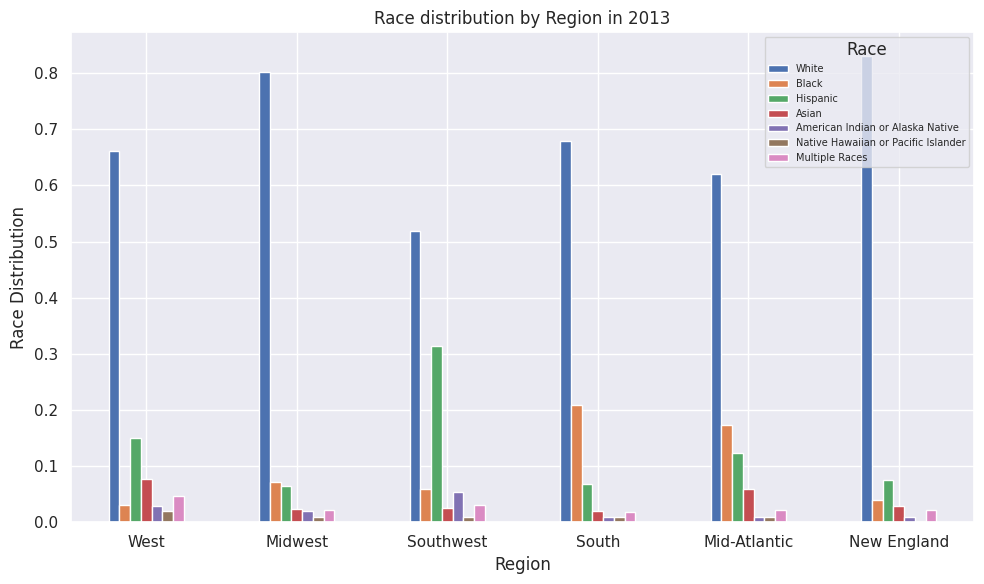

In [ ]:
# Race Distribution by Region in 2013
agg_data = {}
for region in regions:
  filtered_by_region = filtered_race2013_df[filtered_race2013_df["Region"] == region]
  only_numbers = filtered_by_region[['White','Black', 'Hispanic', 'Asian', 'American Indian or Alaska Native', 'Native Hawaiian or Pacific Islander', 'Multiple Races']]
  only_numbers_mean = only_numbers.mean()
  agg_data[region] = only_numbers_mean

race_distribution = pd.DataFrame(agg_data).transpose()

race_distribution.plot(kind='bar', figsize=(10, 6))
plt.title('Race distribution by Region in 2013')
plt.xlabel('Region')
plt.ylabel('Race Distribution')
plt.legend(title='Race', fontsize=7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

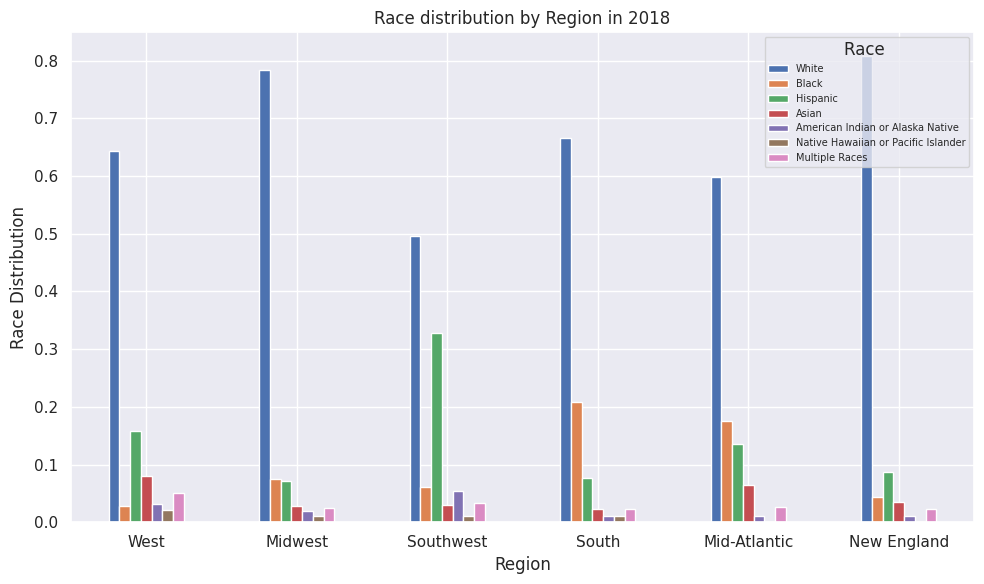

In [ ]:
# Race Distribution by Region in 2018
agg_data = {}
for region in regions:
  filtered_by_region = filtered_race2018_df[filtered_race2018_df["Region"] == region]
  only_numbers = filtered_by_region[['White','Black', 'Hispanic', 'Asian', 'American Indian or Alaska Native', 'Native Hawaiian or Pacific Islander', 'Multiple Races']]
  only_numbers_mean = only_numbers.mean()
  agg_data[region] = only_numbers_mean

race_distribution = pd.DataFrame(agg_data).transpose()

race_distribution.plot(kind='bar', figsize=(10, 6))
plt.title('Race distribution by Region in 2018')
plt.xlabel('Region')
plt.ylabel('Race Distribution')
plt.legend(title='Race ', fontsize=7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
asthma_west = asthma_df[asthma_df['LocationAbbr'].isin(west)]
asthma_midwest = asthma_df[asthma_df['LocationAbbr'].isin(midwest)]
asthma_southwest = asthma_df[asthma_df['LocationAbbr'].isin(southwest)]
asthma_south = asthma_df[asthma_df['LocationAbbr'].isin(south)]
asthma_mid_atlantic = asthma_df[asthma_df['LocationAbbr'].isin(mid_atlantic)]
asthma_new_england = asthma_df[asthma_df['LocationAbbr'].isin(new_england)]

In [ ]:
question_list = list(set(asthma_df['Question']))
question_list

['Asthma prevalence among women aged 18-44 years',
 'Influenza vaccination among noninstitutionalized adults aged >= 65 years with asthma',
 'Emergency department visit rate for asthma',
 'Current asthma prevalence among adults aged >= 18 years',
 'Pneumococcal vaccination among noninstitutionalized adults aged 18-64 years with asthma',
 'Asthma mortality rate',
 'Hospitalizations for asthma',
 'Influenza vaccination among noninstitutionalized adults aged 18-64 years with asthma',
 'Pneumococcal vaccination among noninstitutionalized adults aged >= 65 years with asthma']

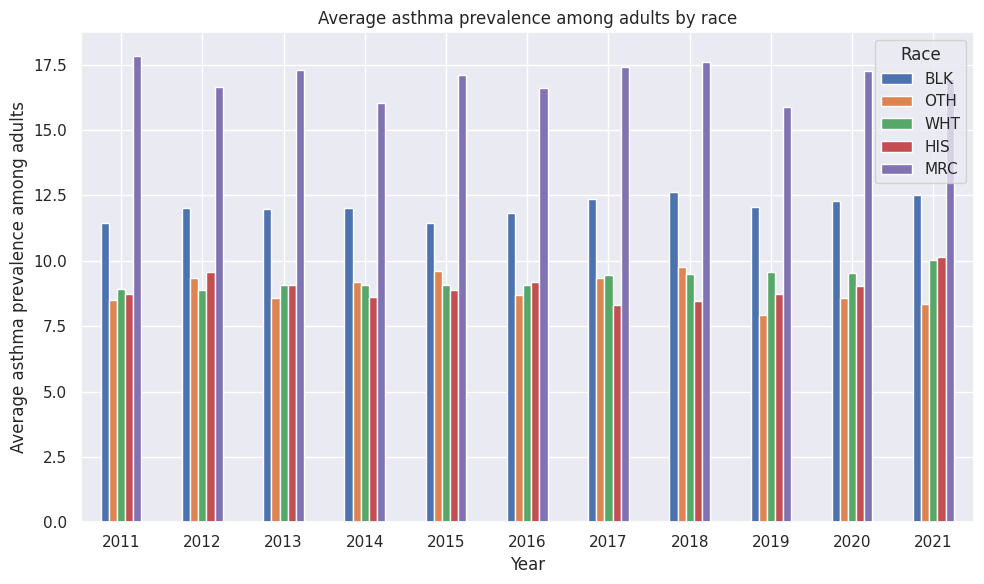

In [ ]:
#Categorical - Bar Chart of Race vs. Average Asthma Hospitalization

stratification_list = list(set(asthma_df['StratificationCategoryID1']))


asthma_df_race = asthma_df[(asthma_df['StratificationCategoryID1'] == 'RACE') & (asthma_df['Question'] == "Current asthma prevalence among adults aged >= 18 years")]
asthma_df_race_means = {}
race_list = list(set(asthma_df_race['StratificationID1']))

for race in race_list:
  filtered_by_race = asthma_df_race[asthma_df_race['StratificationID1'] == race]
  filtered_by_race_mean = filtered_by_race.groupby('YearStart')['DataValue'].mean()
  asthma_df_race_means[race] = filtered_by_race_mean

race_hospitalization = pd.DataFrame(asthma_df_race_means)

race_hospitalization.plot(kind='bar', figsize=(10, 6))
plt.title('Average asthma prevalence among adults by race')
plt.xlabel('Year')
plt.ylabel('Average asthma prevalence among adults')
plt.legend(title='Race')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

percent_missing_data = len(asthma_df_race[asthma_df_race['DataValue'].isna()])/len(asthma_df_race)


#RACE DICTIONARY
#AIAN: American Indian, Alaska Native, Hawaiian Native, Native American, Native People, Indigenous People
#HIS: Hispanic
#WHT: White
#MRC:
#API: Asian and Pacific Islander
#BLK: Black

#NOTES
#2013-2018 because api and aian are missing data before that

In [ ]:
np.sum(asthma_df_race[asthma_df_race['StratificationID1'] == 'OTH']['DataValue'].isna())

444

GRAPH IDEAS:

1. Categorical - Bar Chart of Region vs. Average 'Emergency department visit rate for asthma' over the years for that region
2. Categorical - Line Chart of 'Emergency department visit rate for asthma' over the years, with one line for each region
3. Categorical - Bar Chart of Race (or Gender)  vs. Average 'Emergency department visit rate for asthma' over the years for that region
4. Quantiative -
5. Quantitative -

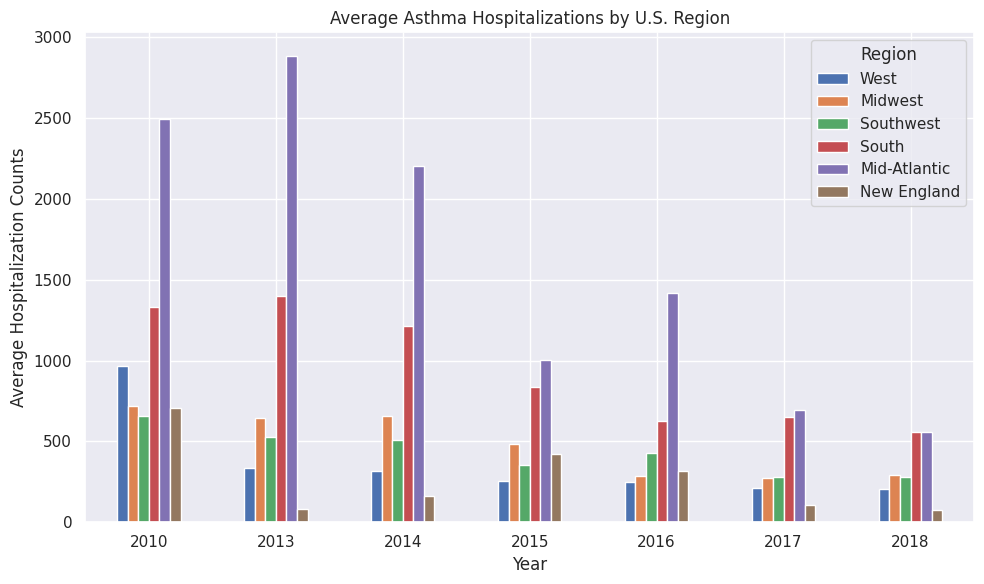

In [ ]:
regions = {'West': west, 'Midwest': midwest, 'Southwest': southwest, 'South': south, 'Mid-Atlantic': mid_atlantic, 'New England': new_england}
agg_data_avg = {}

for name, states in regions.items():
    region_filtered = asthma_df[
        (asthma_df['LocationAbbr'].isin(states)) &
        (asthma_df['Question'].str.contains("Hospitalizations for asthma", na=False))
    ]
    if not region_filtered.empty:
        avg_data = region_filtered.groupby('YearStart')['DataValue'].mean()
        agg_data_avg[name] = avg_data

plot_data_avg = pd.DataFrame(agg_data_avg)

plot_data_avg.plot(kind='bar', figsize=(10, 6))
plt.title('Average Asthma Hospitalizations by U.S. Region')
plt.xlabel('Year')
plt.ylabel('Average Hospitalization Counts')
plt.legend(title='Region')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
#Trends in Particulate Matter by Region
AggAirQuality = pd.read_csv('aggregatedAirQuality.csv')
AggAirQuality['date'] = pd.to_datetime(AggAirQuality['date'])
AggAirQuality.head()

<ipython-input-39-825b8e18a60f>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  AggAirQuality['date'] = pd.to_datetime(AggAirQuality['date'])


,statefips,date,ds_pm_pred,ds_pm_stdd
0,1,2011-04-01,9.407378,3.235884
1,1,2012-04-01,11.620122,4.917164
2,1,2013-04-01,6.637211,1.700115
3,1,2014-04-01,12.504864,7.537256
4,1,2011-08-01,14.477444,2.120518


In [ ]:
west = ['WA', 'MT', 'OR', 'ID', 'WY', 'NV', 'CA', 'UT', 'CO', 'AK', 'HI']
midwest = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH']
southwest = ['AZ', 'NM', 'TX', 'OK']
south = ['AR', 'LA', 'MS', 'AL', 'TN', 'KY', 'WV', 'VA', 'NC', 'SC', 'GA', 'FL', 'DC']
mid_atlantic = ['PA', 'NY', 'NJ', 'MD', 'DE']
new_england = ['ME', 'VT', 'NH', 'MA', 'CT', 'RI']

cwest = [53, 30, 41, 16, 56, 32, 6, 49, 8, 2, 15]
cmidwest = [38, 46, 31, 20, 27, 19, 29, 55, 17, 18, 26, 39]
csouthwest = [4, 35, 48, 40]
csouth = [5, 22, 28, 1, 47, 21, 54, 51, 37, 45, 13, 12, 11]
cmid_atlantic = [42, 36, 34, 24, 10]
cnew_england = [23, 50, 33, 25, 9, 44]

In [ ]:
air_west = AggAirQuality[AggAirQuality['statefips'].isin(cwest)].groupby('date').agg({'ds_pm_pred':'mean'}).reset_index()
air_midwest = AggAirQuality[AggAirQuality['statefips'].isin(cmidwest)].groupby('date').agg({'ds_pm_pred':'mean'})
air_southwest = AggAirQuality[AggAirQuality['statefips'].isin(csouthwest)].groupby('date').agg({'ds_pm_pred':'mean'})
air_south = AggAirQuality[AggAirQuality['statefips'].isin(csouth)].groupby('date').agg({'ds_pm_pred':'mean'})
air_mid_atlantic = AggAirQuality[AggAirQuality['statefips'].isin(cmid_atlantic)].groupby('date').agg({'ds_pm_pred':'mean'})
air_new_england = AggAirQuality[AggAirQuality['statefips'].isin(cnew_england)].groupby('date').agg({'ds_pm_pred':'mean'})


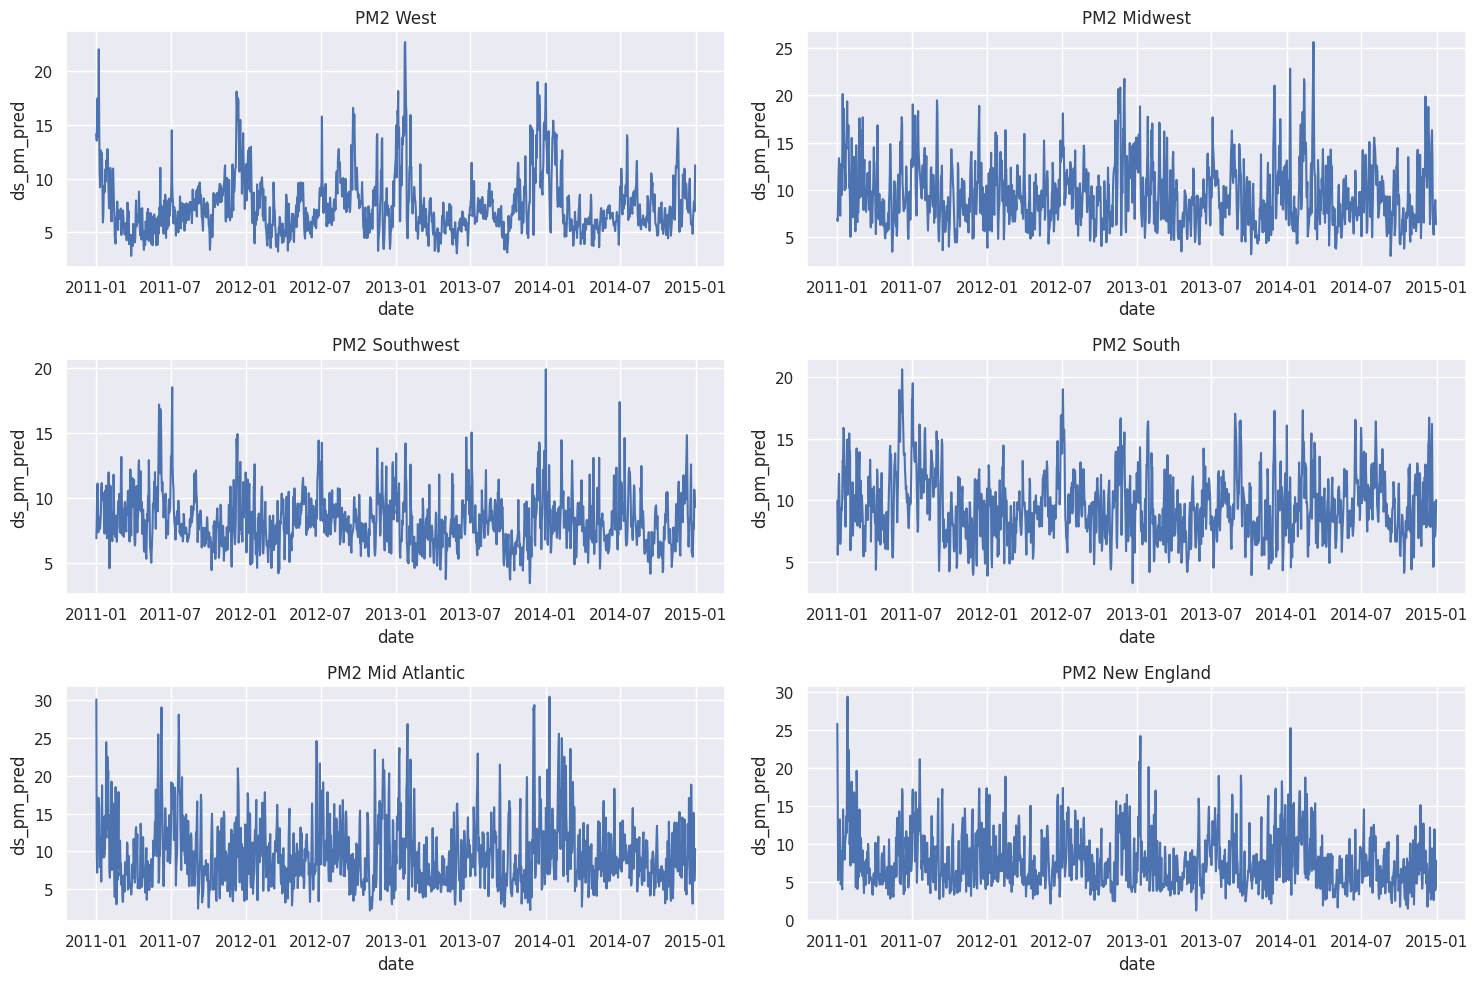

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
sns.lineplot(data=air_west, x = 'date', y ='ds_pm_pred', ax=axs[0,0]).set_title('PM2 West')
sns.lineplot(data=air_midwest, x = 'date', y ='ds_pm_pred', ax=axs[0,1]).set_title('PM2 Midwest')
sns.lineplot(data=air_southwest, x = 'date', y ='ds_pm_pred', ax=axs[1,0]).set_title('PM2 Southwest')
sns.lineplot(data=air_south, x = 'date', y ='ds_pm_pred', ax=axs[1,1]).set_title('PM2 South')
sns.lineplot(data=air_mid_atlantic, x = 'date', y ='ds_pm_pred', ax=axs[2,0]).set_title('PM2 Mid Atlantic')
sns.lineplot(data=air_new_england, x = 'date', y ='ds_pm_pred', ax=axs[2,1]).set_title('PM2 New England')
plt.tight_layout()
plt.show()

In [ ]:
# Trends in Ozone Concentration over Time by Region
  # Mean estimate 8-hour average Ozone Concentration in parts per billion (ppb)
AggOzone = pd.read_csv('aggregatedOzone.csv')
AggOzone['date'] = pd.to_datetime(AggOzone['date'])
AggOzone.head()

<ipython-input-44-0d07ecd77dda>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  AggOzone['date'] = pd.to_datetime(AggOzone['date'])


,statefips,date,ds_o3_pred,ds_o3_stdd
0,1,2011-04-01,45.026941,5.020225
1,1,2012-04-01,40.068685,3.576831
2,1,2013-04-01,46.289012,3.870268
3,1,2014-04-01,50.271390,4.445189
4,1,2011-08-01,48.238357,6.061553


In [ ]:
ozone_west = AggOzone[AggOzone['statefips'].isin(cwest)].groupby('date').agg({'ds_o3_pred':'mean'}).reset_index()
ozone_midwest = AggOzone[AggOzone['statefips'].isin(cmidwest)].groupby('date').agg({'ds_o3_pred':'mean'})
ozone_southwest = AggOzone[AggOzone['statefips'].isin(csouthwest)].groupby('date').agg({'ds_o3_pred':'mean'})
ozone_south = AggOzone[AggOzone['statefips'].isin(csouth)].groupby('date').agg({'ds_o3_pred':'mean'})
ozone_mid_atlantic = AggOzone[AggOzone['statefips'].isin(cmid_atlantic)].groupby('date').agg({'ds_o3_pred':'mean'})
ozone_new_england = AggOzone[AggOzone['statefips'].isin(cnew_england)].groupby('date').agg({'ds_o3_pred':'mean'})

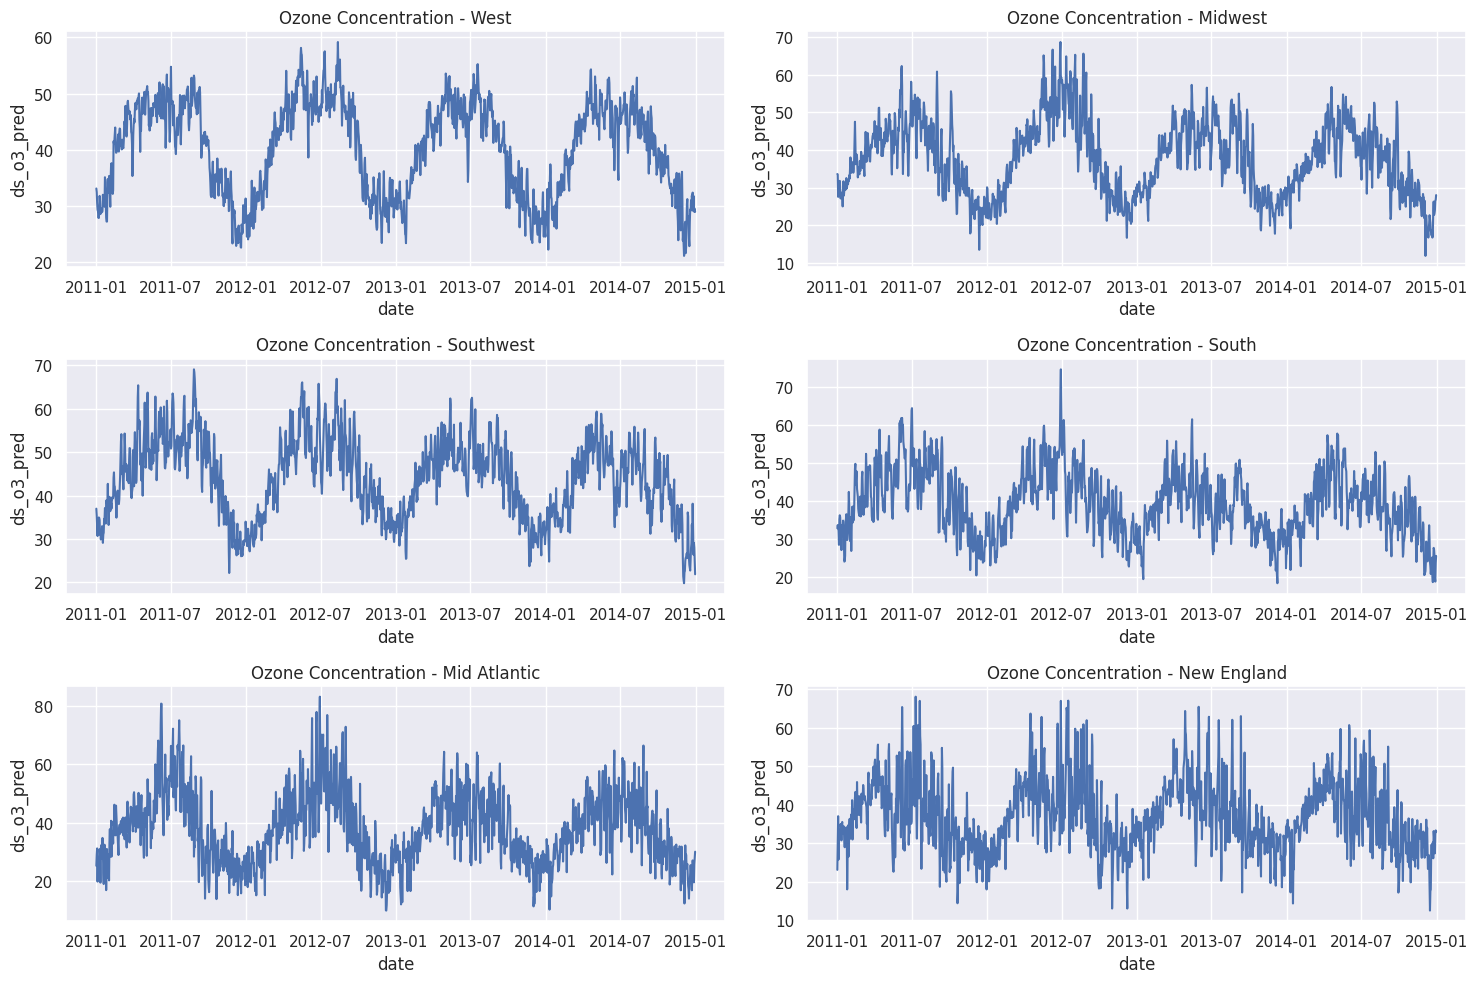

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
sns.lineplot(data=ozone_west, x = 'date', y ='ds_o3_pred', ax=axs[0,0]).set_title('Ozone Concentration - West')
sns.lineplot(data=ozone_midwest, x = 'date', y ='ds_o3_pred', ax=axs[0,1]).set_title('Ozone Concentration - Midwest')
sns.lineplot(data=ozone_southwest, x = 'date', y ='ds_o3_pred', ax=axs[1,0]).set_title('Ozone Concentration - Southwest')
sns.lineplot(data=ozone_south, x = 'date', y ='ds_o3_pred', ax=axs[1,1]).set_title('Ozone Concentration - South')
sns.lineplot(data=ozone_mid_atlantic, x = 'date', y ='ds_o3_pred', ax=axs[2,0]).set_title('Ozone Concentration - Mid Atlantic')
sns.lineplot(data=ozone_new_england, x = 'date', y ='ds_o3_pred', ax=axs[2,1]).set_title('Ozone Concentration - New England')
plt.tight_layout()
plt.show()

**Part II**

In [ ]:
asthma_df
asthma_hospitalization_2013 = asthma_df[(asthma_df['Question']=='Hospitalizations for asthma') & (asthma_df['YearStart']==2013) &
                        (asthma_df['DataValueType'] == 'Number') &
                        (asthma_df['StratificationCategory1'] == 'Overall')]
asthma_hospitalization_2013.loc[:,['LocationDesc','DataValue']]

,LocationDesc,DataValue
59,Puerto Rico,NaN
191,Georgia,NaN
2466,Delaware,NaN
2891,Guam,NaN
5924,Alabama,NaN
6312,California,NaN
6889,Arkansas,2283.0
7026,Alaska,NaN
7451,Connecticut,NaN
7524,District of Columbia,NaN


In [ ]:
pm25_2013 = pd.read_csv('aggregatedPM25.csv')
pm25_2018 = pd.read_csv('aggregatedPM252016.csv')


pm25_2013_avgs = pm25_2013[pm25_2013['date'].str.contains('2013')].groupby('statefips').agg({'ds_pm_pred':'mean'})
pm25_2018_avgs = pm25_2018[pm25_2018['date'].str.contains('2018')].groupby('statefips').agg({'DS_PM_pred':'mean'})
pm25_avgs = pm25_2013_avgs.merge(pm25_2018_avgs, on = 'statefips')
changes_in_pm25 = pm25_avgs['ds_pm_pred'] - pm25_avgs['DS_PM_pred']


#notes
changes_in_pm25_sorted = changes_in_pm25.sort_values()
treatment = changes_in_pm25[changes_in_pm25 >= 1.23778]
control = changes_in_pm25[(changes_in_pm25 <= 0.48583) & (changes_in_pm25 >= -0.19279)]

In [ ]:
#confounders

#change in poverty levels - measured in proportion of population in poverty
state_poverty_levels = pd.read_csv('us-state-poverty.csv')
state_poverty_levels = state_poverty_levels.rename(columns = {"stname": "Location"})
state_poverty_levels['2013'] = state_poverty_levels['2013']/100
state_poverty_levels['2018'] = state_poverty_levels['2018']/100
poverty_level_change = pd.DataFrame()
poverty_level_change['Location'] = state_poverty_levels['Location']
poverty_level_change['statefips'] = state_poverty_levels['statefips']
poverty_level_change['Poverty Level'] = state_poverty_levels['2018'] - state_poverty_levels['2013']

#change in age distributions - measured in proportion of each age group
state_age_dist_2013 = pd.read_csv('us-age-2013.csv')
state_age_dist_2018 = pd.read_csv('us-age-2018.csv')
age_dist_change = pd.DataFrame()
age_dist_change["Location"] = state_age_dist_2013["Location"]
age_dist_change["Children 0-18"] = state_age_dist_2018["Children 0-18"]  - state_age_dist_2013["Children 0-18"]
age_dist_change["Adults 19-25"] = state_age_dist_2018["Adults 19-25"]  - state_age_dist_2013["Adults 19-25"]
age_dist_change["Adults 26-34"] = state_age_dist_2018["Adults 26-34"]  - state_age_dist_2013["Adults 26-34"]
age_dist_change["Adults 35-54"] = state_age_dist_2018["Adults 35-54"]  - state_age_dist_2013["Adults 35-54"]
age_dist_change["Adults 55-64"] = state_age_dist_2018["Adults 55-64"]  - state_age_dist_2013["Adults 55-64"]
#^left out the age group of 65+ to prevent columns from summing to 1


#change in gender distributions - measured in proportion of each gender
state_gender_dist_2013 = pd.read_csv('us-gender-2013.csv')
state_gender_dist_2018 = pd.read_csv('us-gender-2018.csv')
gender_dist_change = pd.DataFrame()
gender_dist_change['Location'] = state_gender_dist_2013['Location']
gender_dist_change["Male"] = state_gender_dist_2018["Male"] - state_gender_dist_2013["Male"]
#^left out female column to prevent columns from summing to 1


#change in race distributions - measured in proportion of each race
state_race_dist_2013 = pd.read_csv('us-race-2013.csv')
state_race_dist_2013 = state_race_dist_2013.replace("<.01", 0.01)
state_race_dist_2013 = state_race_dist_2013.replace("N/A", 0)
state_race_dist_2013 = state_race_dist_2013.replace("NaN", 0)
#^NA indicated values that were very small so replaced it with 0
state_race_dist_2013['Black'] = state_race_dist_2013['Black'].astype(float)
state_race_dist_2013['American Indian or Alaska Native'] = state_race_dist_2013['American Indian or Alaska Native'].astype(float)

state_race_dist_2018 = pd.read_csv('us-race-2018.csv')
state_race_dist_2018 = state_race_dist_2018.replace("<.01", 0.01)
state_race_dist_2018 = state_race_dist_2018.replace("N/A", 0)
state_race_dist_2018 = state_race_dist_2018.replace("NaN", 0)
state_race_dist_2018['Black'] = state_race_dist_2018['Black'].astype(float)
state_race_dist_2018['American Indian or Alaska Native'] = state_race_dist_2018['American Indian or Alaska Native'].astype(float)


race_dist_change = pd.DataFrame()
race_dist_change['Location'] = state_race_dist_2013['Location']
race_dist_change['White'] = state_race_dist_2018['White'] - state_race_dist_2013['White']
race_dist_change['Black'] = state_race_dist_2018['Black'] - state_race_dist_2013['Black']
race_dist_change['Hispanic'] = state_race_dist_2018['Hispanic'] - state_race_dist_2013['Hispanic']
race_dist_change['Asian'] = state_race_dist_2018['Asian'] - state_race_dist_2013['Asian']
race_dist_change['American Indian or Alaska Native'] = state_race_dist_2018['American Indian or Alaska Native'] - state_race_dist_2013['American Indian or Alaska Native']
#^left out Native Hawaiian or Pacific Islander and Multiple Races columns to prevent columns from summing to 1

#change in unemployment - measured in proportion unemployed
state_unemployment_2013 = pd.read_csv('us-unemployment-2013.csv')
state_unemployment_2018 = pd.read_csv('us-unemployment-2018.csv')
unemployment_change = pd.DataFrame()
unemployment_change['Location'] = state_unemployment_2013['Location']
unemployment_change["Unemployed"] = state_unemployment_2018["Unemployed"] - state_unemployment_2013["Unemployed"]

#change in hospitals - measured in proportional change (change in hospitals / hospitals in 2013)
state_hospitals_2013 = pd.read_csv('us-hospitals-2013.csv')
state_hospitals_2018 = pd.read_csv('us-hospitals-2018.csv')
hospitals_change = pd.DataFrame()
hospitals_change['Location'] = state_hospitals_2013['Location']
hospitals_change['Hospitals'] = (state_hospitals_2018['Total Hospitals'] - state_hospitals_2013['Total Hospitals']) / state_hospitals_2013['Total Hospitals']

#change in hospital beds per 1000 - measured in proportional change (change in hospital beds per 1000 / hospital beds per 1000 in 2013)
state_hospital_beds_per_1000_2013 = pd.read_csv('us-hospitalbeds-per1000-2013.csv')
state_hospital_beds_per_1000_2018 = pd.read_csv('us-hospitalbeds-per1000-2018.csv')
hosptial_beds_per_1000_change = pd.DataFrame()
hosptial_beds_per_1000_change['Location'] = state_hospital_beds_per_1000_2013['Location']
hosptial_beds_per_1000_change['Hospital Beds Per 1000'] = (state_hospital_beds_per_1000_2018["Total"] - state_hospital_beds_per_1000_2013["Total"])/state_hospital_beds_per_1000_2013["Total"]


#Change in Health Care Expenditures by State of Provider (in millions) - measured in proportional change of expenditure (change in expenditure / expenditure in 2013)
state_healthcare_expenditures_2013 = pd.read_csv('us_health_spending_2013.csv')
state_healthcare_expenditures_2013['Total Health Spending'] = state_healthcare_expenditures_2013['Total Health Spending'].str.replace("$","")
state_healthcare_expenditures_2013['Total Health Spending'] = state_healthcare_expenditures_2013['Total Health Spending'].astype(float)
state_healthcare_expenditures_2018 = pd.read_csv('us_health_spending_2018.csv')
state_healthcare_expenditures_2018['Total Health Spending'] = state_healthcare_expenditures_2018['Total Health Spending'].str.replace("$","")
state_healthcare_expenditures_2018['Total Health Spending'] = state_healthcare_expenditures_2018['Total Health Spending'].astype(float)

healthcare_expenditures_change = pd.DataFrame()
healthcare_expenditures_change['Location'] = state_healthcare_expenditures_2013['Location']
healthcare_expenditures_change['Healthcare Spending'] = (state_healthcare_expenditures_2018['Total Health Spending'] -  state_healthcare_expenditures_2013['Total Health Spending'])/ state_healthcare_expenditures_2013['Total Health Spending']


#Making the confounder dataframe witl all identified confounders

confounders = poverty_level_change.merge(age_dist_change, on = "Location")
confounders = confounders.merge(gender_dist_change, on = "Location")
confounders = confounders.merge(race_dist_change, on = "Location")
confounders = confounders.merge(unemployment_change, on = "Location")
confounders = confounders.merge(hospitals_change, on = "Location")
confounders = confounders.merge(hosptial_beds_per_1000_change, on = "Location")
confounders = confounders.merge(healthcare_expenditures_change, on = "Location")
confounders


,Location,statefips,Poverty Level,Children 0-18,Adults 19-25,Adults 26-34,Adults 35-54,Adults 55-64,Male,White,Black,Hispanic,Asian,American Indian or Alaska Native,Unemployed,Hospitals,Hospital Beds Per 1000,Healthcare Spending
0,Alabama,1,-0.019,-0.011,-0.006,0.004,-0.014,0.005,0.000,-0.010,0.003,0.004,0.002,0.000,-0.026,0.041237,0.009677,0.213086
1,Alaska,2,0.016,-0.002,-0.019,-0.004,-0.007,0.007,-0.010,-0.024,-0.005,0.008,0.011,0.018,-0.001,-0.045455,0.061905,0.259726
2,Arizona,4,-0.046,-0.014,-0.003,0.001,-0.009,0.003,0.000,-0.023,0.003,0.014,0.003,0.000,-0.032,0.152778,-0.035000,0.334149
3,Arkansas,5,-0.025,-0.006,-0.002,0.000,-0.012,0.003,-0.005,-0.016,-0.004,0.008,0.003,0.000,-0.041,0.047619,-0.012500,0.262808
4,California,6,-0.040,-0.012,-0.009,0.008,-0.009,0.006,0.000,-0.022,-0.001,0.009,0.010,0.000,-0.047,0.034582,0.022222,0.298390
5,Colorado,8,-0.034,-0.013,-0.006,0.009,-0.010,-0.001,0.000,-0.014,0.002,0.005,0.003,0.000,-0.031,0.085366,-0.070000,0.352981
6,Connecticut,9,-0.003,-0.013,0.002,0.001,-0.021,0.010,-0.001,-0.032,0.003,0.020,0.006,0.000,-0.038,-0.030303,-0.086364,0.198529
7,Delaware,10,0.001,-0.015,-0.005,0.000,-0.022,0.010,-0.003,-0.022,0.008,0.006,0.004,0.000,-0.030,0.000000,-0.009091,0.247162
8,District of Columbia,11,-0.027,0.008,-0.017,0.005,0.003,-0.006,0.004,0.016,-0.037,0.009,0.005,NaN,-0.028,-0.090909,-0.207143,0.358934
9,Florida,12,-0.034,-0.008,-0.008,0.006,-0.014,0.005,-0.001,-0.030,-0.001,0.025,0.001,0.000,-0.036,0.023585,-0.044444,0.308879


In [ ]:
#preparing aggregated dataset

pm25_data = pd.DataFrame()
pm25_data['statefips'] = changes_in_pm25.index


pm25_data['Change in PM 2.5'] = changes_in_pm25.values

#Assign Outcome
asthma_hospitalization_rate_2013 = asthma_df[(asthma_df['Question']=='Hospitalizations for asthma') & (asthma_df['YearStart']==2013) &
                        (asthma_df['DataValueType'] == 'Age-adjusted Rate') &
                        (asthma_df['StratificationCategory1'] == 'Overall')]
asthma_hospitalization_rate_2013 = asthma_hospitalization_rate_2013.rename(columns = {'DataValue': 'DataValue2013'})
asthma_hospitalization_rate_2013 = asthma_hospitalization_rate_2013.loc[:,['LocationDesc','DataValue2013']]

asthma_hospitalization_rate_2018 = asthma_df[(asthma_df['Question']=='Hospitalizations for asthma') & (asthma_df['YearStart']==2018) &
                        (asthma_df['DataValueType'] == 'Age-adjusted Rate') &
                        (asthma_df['StratificationCategory1'] == 'Overall')]
asthma_hospitalization_rate_2018 = asthma_hospitalization_rate_2018.rename(columns = {'DataValue': 'DataValue2018'})
asthma_hospitalization_rate_2018 = asthma_hospitalization_rate_2018.loc[:,['LocationDesc','DataValue2018']]

change_in_hospitalization_rate = asthma_hospitalization_rate_2013.merge(asthma_hospitalization_rate_2018, on = 'LocationDesc')
change_in_hospitalization_rate["Change"] = change_in_hospitalization_rate["DataValue2018"] - change_in_hospitalization_rate["DataValue2013"]
change_in_hospitalization_rate = change_in_hospitalization_rate.rename(columns = {'LocationDesc':'Location'})

fips_state_map = confounders.loc[:,['Location', 'statefips']]
change_in_hospitalization_rate = change_in_hospitalization_rate.merge(fips_state_map, on = 'Location')
change_in_hospitalization_rate = change_in_hospitalization_rate.loc[:,['Change', 'statefips']]
pm25_data = pm25_data.merge(change_in_hospitalization_rate, on = 'statefips')
pm25_data = pm25_data.rename(columns = {'Change':'Outcome'})

#Get rid of observations with no outcome observed because those cannot be used in the analysis

pm25_data = pm25_data.dropna(subset = ['Outcome'])
pm25_data.sort_values(by = 'Change in PM 2.5')

#Assign treatment and control
pm25_data = pm25_data[((pm25_data['Change in PM 2.5'] >= 1) | (pm25_data['Change in PM 2.5'] <= 0.33))]
pm25_data['Treatment'] = np.where(pm25_data['Change in PM 2.5'] >= 1, 1, 0)

#adding on confounders
pm25_asthma_data = pm25_data.merge(confounders, on = 'statefips')
pm25_asthma_data

,statefips,Change in PM 2.5,Outcome,Treatment,Location,Poverty Level,Children 0-18,Adults 19-25,Adults 26-34,Adults 35-54,...,Male,White,Black,Hispanic,Asian,American Indian or Alaska Native,Unemployed,Hospitals,Hospital Beds Per 1000,Healthcare Spending
0,4,-0.621184,-4.31,0,Arizona,-0.046,-0.014,-0.003,0.001,-0.009,...,0.000,-0.023,0.003,0.014,0.003,0.000,-0.032,0.152778,-0.035000,0.334149
1,8,-0.746273,-3.01,0,Colorado,-0.034,-0.013,-0.006,0.009,-0.010,...,0.000,-0.014,0.002,0.005,0.003,0.000,-0.031,0.085366,-0.070000,0.352981
2,12,-1.061173,-7.28,0,Florida,-0.034,-0.008,-0.008,0.006,-0.014,...,-0.001,-0.030,-0.001,0.025,0.001,0.000,-0.036,0.023585,-0.044444,0.308879
3,19,1.131655,-3.20,1,Iowa,-0.015,-0.003,-0.002,0.000,-0.013,...,0.002,-0.021,0.002,0.007,0.006,0.000,-0.021,0.000000,-0.065625,0.154650
4,21,1.206879,-6.72,1,Kentucky,-0.019,-0.008,-0.002,0.002,-0.016,...,-0.002,-0.012,0.000,0.004,0.003,0.000,-0.040,-0.009434,0.003125,0.250811
5,26,0.329055,-5.66,0,Michigan,-0.029,-0.012,-0.005,0.011,-0.021,...,0.001,-0.012,-0.001,0.005,0.005,0.000,-0.049,-0.046358,0.000000,0.197651
6,32,0.285977,-2.86,0,Nevada,-0.029,-0.013,-0.007,0.003,-0.008,...,-0.001,-0.037,0.008,0.015,0.004,0.000,-0.051,0.157895,0.070000,0.357597
7,34,1.004353,-7.50,1,New Jersey,-0.019,-0.010,-0.001,0.001,-0.018,...,0.000,-0.028,0.002,0.018,0.007,0.000,-0.040,0.064935,-0.020833,0.250625
8,41,-0.121182,-1.97,0,Oregon,-0.041,-0.011,-0.006,0.008,-0.007,...,0.001,-0.023,0.002,0.010,0.007,0.000,-0.035,0.033898,-0.029412,0.321010
9,45,1.028021,-6.68,1,South Carolina,-0.033,-0.008,-0.008,0.001,-0.014,...,0.000,-0.004,-0.009,0.006,0.003,0.000,-0.041,0.000000,-0.118519,0.206542


In [ ]:
#BUILDING THE MODEL

#estimate ˆe(x) (the predicted probability that zi = 1) by fitting a logistic regression model that predicts zi from xi .
Z = pm25_asthma_data['Treatment']
Y = pm25_asthma_data['Outcome']
X = pm25_asthma_data.iloc[:,5:13]
from sklearn.linear_model import LogisticRegression as LR
lr = LR(penalty='none', max_iter=200, random_state=0)
lr.fit(X, Z)

#estimate average treatment effect counting for the propensity
def estimate_treatment_effect(lr, X, Y, Z):
  ex = lr.predict_proba(X)[:, 1]
  return np.mean(Z * Y / ex) - np.mean((1 - Z) * Y / (1 - ex))

ete = estimate_treatment_effect(lr, X, Y, Z)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [ ]:
#Testing for significance
from scipy.stats import ttest_ind

def confidence_intervals(lr, X, Y, Z):
  ex = lr.predict_proba(X)[:, 1]
  treatment = Z * Y / ex
  control = (1 - Z) * Y / (1 - ex)
  t_stat, p_val = ttest_ind(treatment, control)
  n_treated = 7
  n_control = 7
  std_err = ((treatment.std() ** 2 / n_treated) + (control.std() ** 2 / n_control)) ** 0.5
  #Building a 95% confidence interval
  z_val = stats.norm.ppf(0.975)
  ci_lower = ete - z_val *  std_err
  ci_upper = ete + z_val *  std_err
  return ci_lower, ci_upper

confidence_intervals(lr, X, Y, Z)




(-2.936638437063107, 3.020877361303987)

In [ ]:
fips_df = pd.read_csv('state_fips.csv')
# FIPS codes for each state
state_to_fips = {
    "Alabama": 1, "Alaska": 2, "Arizona": 4, "Arkansas": 5, "California": 6,
    "Colorado": 8, "Connecticut": 9, "Delaware": 10, "Florida": 12, "Georgia": 13,
    "Hawaii": 15, "Idaho": 16, "Illinois": 17, "Indiana": 18, "Iowa": 19,
    "Kansas": 20, "Kentucky": 21, "Louisiana": 22, "Maine": 23, "Maryland": 24,
    "Massachusetts": 25, "Michigan": 26, "Minnesota": 27, "Mississippi": 28, "Missouri": 29,
    "Montana": 30, "Nebraska": 31, "Nevada": 32, "New Hampshire": 33, "New Jersey": 34,
    "New Mexico": 35, "New York": 36, "North Carolina": 37, "North Dakota": 38, "Ohio": 39,
    "Oklahoma": 40, "Oregon": 41, "Pennsylvania": 42, "Rhode Island": 44, "South Carolina": 45,
    "South Dakota": 46, "Tennessee": 47, "Texas": 48, "Utah": 49, "Vermont": 50,
    "Virginia": 51, "Washington": 53, "West Virginia": 54, "Wisconsin": 55, "Wyoming": 56
}

# Regions dictionary
regions = {
    "Northeast": ["Maine", "New Hampshire", "Vermont", "Massachusetts", "Rhode Island", "Connecticut", "New York", "New Jersey"],
    "Mid-Atlantic": ["Pennsylvania", "Delaware", "Maryland", "Virginia", "West Virginia", "North Carolina", "South Carolina", "Kentucky"],
    "Midwest": ["Ohio", "Michigan", "Indiana", "Illinois", "Wisconsin", "Minnesota", "Iowa", "Missouri"],
    "Central": ["North Dakota", "South Dakota", "Nebraska", "Kansas", "Montana", "Wyoming", "Colorado", "Utah", "Oklahoma"],
    "South": ["Tennessee", "Mississippi", "Alabama", "Georgia", "Florida", "Arkansas", "Louisiana", "Texas"],
    "West": ["New Mexico", "Arizona", "Nevada", "California", "Oregon", "Washington", "Alaska", "Hawaii", "Idaho"]
}

# Replace state names with FIPS codes
regions_fips = {region: [state_to_fips[state] for state in states] for region, states in regions.items()}

In [ ]:
# Load Air Quality DF
air_quality_df = pd.read_csv('aggregatedAirQuality.csv')

# Assign regions to each data point in Air Quality
def assign_region(statefips):
    for region, states in regions_fips.items():
        if statefips in states:
            return region
    return 'Other'

air_quality_df['region'] = air_quality_df['statefips'].apply(assign_region)

# Clean Air Quality DF
air_quality_df['date'] = pd.to_datetime(air_quality_df['date'])
air_quality_df['year'] = air_quality_df['date'].dt.year
air_quality_df = air_quality_df.groupby(['year', 'statefips'])[['ds_pm_pred', 'ds_pm_stdd']].mean().reset_index()
air_quality_df = air_quality_df[air_quality_df['year'] == 2013]
air_quality_df = air_quality_df.drop(columns=['ds_pm_stdd', 'year'])
air_quality_df.reset_index(drop=True, inplace=True)
air_quality_df.head()

<ipython-input-57-19bf34d72720>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  air_quality_df['date'] = pd.to_datetime(air_quality_df['date'])


,statefips,ds_pm_pred
0,1,10.038904
1,4,6.685641
2,5,9.724699
3,6,10.603372
4,8,6.481582


In [ ]:
# Load Asthma DF
asthma_df = pd.read_csv('asthma_prevalence.csv')

# Clean Asthma DF
asthma_df = asthma_df.drop(columns=['Number with Current Asthma'])
asthma_df['Percent with Current Asthma'] = asthma_df['Percent with Current Asthma']*0.01
asthma_df = asthma_df.rename(columns={"Percent with Current Asthma": "asthma_percentage", "State or Territory": "state_name"})
asthma_df.head()

,state_name,asthma_percentage
0,Alabama,0.095
1,Alaska,0.081
2,Arizona,0.096
3,Arkansas,0.088
4,California,0.078


In [ ]:
# Load State Population DF
state_pop_df = pd.read_csv('state_pop.csv')

# Clean State Population DF
state_pop_df = state_pop_df[['NAME', 'POPESTIMATE2014']]
state_pop_df = state_pop_df.drop([0, 1, 2, 3, 4, 13, 56])
state_pop_df.reset_index(drop=True, inplace=True)
state_pop_df = state_pop_df.rename(columns={"POPESTIMATE2014": "pop_estimate", "NAME": "state_name"})
state_pop_df.head()

,state_name,pop_estimate
0,Alabama,4843737
1,Alaska,737075
2,Arizona,6732873
3,Arkansas,2968759
4,California,38586706


In [ ]:
# Load Median Income DF
median_income_df = pd.read_csv('median_income.csv')

# Clean Median Income DF
median_income_df = median_income_df.drop([0, 9])
median_income_df.reset_index(drop=True, inplace=True)
median_income_df['2014 Median\nincome'] = median_income_df['2014 Median\nincome'].str.replace(',', '').astype(int)
median_income_df = median_income_df.rename(columns={"2014 Median\nincome": "med_income", "State": "state_name"})
median_income_df.head()

,state_name,med_income
0,Alabama,42278
1,Alaska,67629
2,Arizona,49254
3,Arkansas,44922
4,California,60487


In [ ]:
# Load Uninsured Percent DF
uninsured_df = pd.read_csv('uninsured_percent.csv')

# Clean Uninsured Percent DF
uninsured_df = uninsured_df.rename(columns={"Uninsured": "uninsured_percentage", "Location": "state_name"})
uninsured_df.head()

,state_name,uninsured_percentage
0,Alabama,0.120
1,Alaska,0.175
2,Arizona,0.137
3,Arkansas,0.118
4,California,0.125


In [ ]:
# Merge Everything Together
df_list = [fips_df, asthma_df, state_pop_df, median_income_df, uninsured_df]
df_merged = reduce(lambda  left,right: pd.merge(left, right, on=['state_name'], how='outer'), df_list)
df_merged = df_merged.drop(8)
df_merged.reset_index(drop=True, inplace=True)
df_merged.head()

,state_name,statefips,asthma_percentage,pop_estimate,med_income,uninsured_percentage
0,Alabama,1,0.095,4843737.0,42278.0,0.120
1,Alaska,2,0.081,737075.0,67629.0,0.175
2,Arizona,4,0.096,6732873.0,49254.0,0.137
3,Arkansas,5,0.088,2968759.0,44922.0,0.118
4,California,6,0.078,38586706.0,60487.0,0.125


In [ ]:
air_quality_df

final_df = pd.merge(air_quality_df, df_merged, on=['statefips'])
final_df.head()

,statefips,ds_pm_pred,state_name,asthma_percentage,pop_estimate,med_income,uninsured_percentage
0,1,10.038904,Alabama,0.095,4843737.0,42278.0,0.120
1,4,6.685641,Arizona,0.096,6732873.0,49254.0,0.137
2,5,9.724699,Arkansas,0.088,2968759.0,44922.0,0.118
3,6,10.603372,California,0.078,38586706.0,60487.0,0.125
4,8,6.481582,Colorado,0.084,5352637.0,60940.0,0.106


In [ ]:
# Assign Regions
def assign_region(statefips):
    for region, states in regions_fips.items():
        if statefips in states:
            return region
    return 'Other'

final_df['region'] = final_df['statefips'].apply(assign_region)
final_df.head()

,statefips,ds_pm_pred,state_name,asthma_percentage,pop_estimate,med_income,uninsured_percentage,region
0,1,10.038904,Alabama,0.095,4843737.0,42278.0,0.120,South
1,4,6.685641,Arizona,0.096,6732873.0,49254.0,0.137,West
2,5,9.724699,Arkansas,0.088,2968759.0,44922.0,0.118,South
3,6,10.603372,California,0.078,38586706.0,60487.0,0.125,West
4,8,6.481582,Colorado,0.084,5352637.0,60940.0,0.106,Central


In [ ]:
# Group the data by region
regions = final_df['region'].unique()
results = []

for region in regions:
    # Filter data for the region
    region_data = final_df[final_df['region'] == region]

    # Fit the regression model
    model = smf.ols('asthma_percentage ~ ds_pm_pred + pop_estimate + med_income + uninsured_percentage', data=region_data)
    result = model.fit()

    # Collect results
    results.append({
        'Region': region,
        'Intercept': result.params['Intercept'],
        'ds_pm_pred_Coeff': result.params['ds_pm_pred'],
        'ds_pm_pred_pvalue': result.pvalues['ds_pm_pred'],
        'Adjusted R-squared': result.rsquared_adj,
        'Model F-statistic p-value': result.f_pvalue
    })

results_df = pd.DataFrame(results)
print(results_df)

         Region  Intercept  ds_pm_pred_Coeff  ds_pm_pred_pvalue  \
0         South   0.126624         -0.001225           0.672297   
1          West   0.637756          0.019850           0.015257   
2       Central   0.061742         -0.000285           0.869921   
3     Northeast   0.238492         -0.012748           0.111781   
4  Mid-Atlantic   0.100205          0.006977           0.561457   
5       Midwest   0.250335         -0.008650           0.188517   

   Adjusted R-squared  Model F-statistic p-value  
0            0.609390                   0.154035  
1            0.981969                   0.011985  
2            0.028505                   0.478627  
3            0.729230                   0.091946  
4            0.445970                   0.248043  
5            0.553364                   0.185320  


In [ ]:
alpha = 0.05

# Sort the DataFrame by p-value
bh_results_df = results_df.sort_values(by='ds_pm_pred_pvalue').reset_index(drop=True)

# Compute the cumulative Benjamini-Hochberg critical values
m = len(bh_results_df)  # Total number of tests
bh_results_df['BH_Critical_Value'] = [alpha * (i + 1) / m for i in range(m)]

# Apply the Benjamini-Hochberg correction
bh_results_df['BH_Reject'] = bh_results_df['ds_pm_pred_pvalue'] <= bh_results_df['BH_Critical_Value']

print(bh_results_df)

         Region  Intercept  ds_pm_pred_Coeff  ds_pm_pred_pvalue  \
0          West   0.637756          0.019850           0.015257   
1     Northeast   0.238492         -0.012748           0.111781   
2       Midwest   0.250335         -0.008650           0.188517   
3  Mid-Atlantic   0.100205          0.006977           0.561457   
4         South   0.126624         -0.001225           0.672297   
5       Central   0.061742         -0.000285           0.869921   

   Adjusted R-squared  Model F-statistic p-value  BH_Critical_Value  BH_Reject  
0            0.981969                   0.011985           0.008333      False  
1            0.729230                   0.091946           0.016667      False  
2            0.553364                   0.185320           0.025000      False  
3            0.445970                   0.248043           0.033333      False  
4            0.609390                   0.154035           0.041667      False  
5            0.028505                   0.47

In [ ]:
alpha = 0.05
bonferroni_alpha = alpha / len(regions)
bh_results_df['Bonferroni_Reject'] = bh_results_df['ds_pm_pred_pvalue'] < bonferroni_alpha

num_bonferroni_rejections = bh_results_df['Bonferroni_Reject'].sum()
num_bh_rejections = bh_results_df['BH_Reject'].sum()

print("Number of Discoveries by Bonferroni Correction:", num_bonferroni_rejections)
print("Number of Discoveries by B-H Procedure:", num_bh_rejections)

Number of Discoveries by Bonferroni Correction: 0
Number of Discoveries by B-H Procedure: 0


In [ ]:
bh_results_df

,Region,Intercept,ds_pm_pred_Coeff,ds_pm_pred_pvalue,Adjusted R-squared,Model F-statistic p-value,BH_Critical_Value,BH_Reject,Bonferroni_Reject
0,West,0.637756,0.019850,0.015257,0.981969,0.011985,0.008333,False,False
1,Northeast,0.238492,-0.012748,0.111781,0.729230,0.091946,0.016667,False,False
2,Midwest,0.250335,-0.008650,0.188517,0.553364,0.185320,0.025000,False,False
3,Mid-Atlantic,0.100205,0.006977,0.561457,0.445970,0.248043,0.033333,False,False
4,South,0.126624,-0.001225,0.672297,0.609390,0.154035,0.041667,False,False
5,Central,0.061742,-0.000285,0.869921,0.028505,0.478627,0.050000,False,False


In [ ]:
effect_size = 0.5  # Hypothetical effect size (Cohen's d)
sample_size = 9  # Number of observations per group

analysis = smp.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, alpha=bonferroni_alpha, nobs1=sample_size, power=None, ratio=1.0)

print('Computed power of the test: {:.3f}'.format(result))

Computed power of the test: 0.046
